# C14-hepatocyte analysis

default_parameters -> fit

default_limit -> physical

parameters -> physical

In [1]:
import datetime
from IPython.display import display
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline

mem = joblib.Memory(location='/scratch/tmp/fabrost/male_vs_female', verbose=0)

import logging

%load_ext rpy2.ipython

# logging.basicConfig(filename='c14.log',
#                             filemode='a',
#                             format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
#                             datefmt='%H:%M:%S',
#                             level=logging.INFO)
logging.basicConfig(level=logging.INFO)

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

In [3]:
# %load_ext autoreload
# %autoreload 2
import c14
import c14.models.liver
import c14.models.minimal

## Data

In [18]:
data = pd.read_csv('../../../results/C14data_liver_samples_20190827.csv')

In [22]:
sex = data[['sample', 'sex']].drop_duplicates()

In [23]:
data = data.groupby(['type', 'sample', 'ploidy', 'pathology']).mean().dropna(how='all').reset_index()
data['age'] = data['Dcoll'] - data['Dbirth']
data = data.query('type == "hepatocyte" and pathology != "Y"')

In [28]:
data = data.merge(sex, on='sample')

In [30]:
edata_female = c14.exp_data(data.query('sex == "F"'))
edata_male = c14.exp_data(data.query('sex == "M"'))

## Fit the models

In [32]:
@mem.cache
def fit_model(edata, model, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    print(f'Fitting model {model.__name__}')
    result = {'model': model()}
    result['op'] = c14.optimize(model=result['model'],data=edata,step_size=step_size)
    result['vis'] = c14.visualisze(model=result['model'],data=edata,step_size=2)
    result['multistart_result'] = result['op'].optimize_minuit_multistart(**optimize_minuit_multistart_kwargs)
    try:
        result['point_estimate'] = result['multistart_result'].sort_values('fval').iloc[0]['values']
        result['cov'] = result['multistart_result'].sort_values('fval').iloc[0]['cov']
    except:
        print(f'Multistart found no valid results for model {model.__name__}')
    try:
        result['errors'] = result['vis'].calc_error(result['point_estimate'], result['cov'])
    except:
        print(f'Could not calculate errors for {model.__name__}')
    return result

In [33]:
def fit_models(edata, models, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    results = {model.__name__: fit_model(edata, model, step_size, optimize_minuit_multistart_kwargs)
               for model in models}
    return results

In [36]:
# models = c14.models.liver.models_list + c14.models.minimal.models_list
models = [c14.models.liver.Akr40]
models

[c14.models.liver.Akr40]

In [37]:
init_limit = {'r2': (-3, 0), 
              'r4': (-3, 0),
              'kappa24': (-3, 0),
              'kappa42': (-3, 0),
              'delta2': (-3, 0),
              'delta2_0': (-3, 0),
              'delta2_100': (-3, 0),
              'delta4': (-3, 0),
              'f': (1, 3),
              'lambda_': (-3, 0),
              'r_0': (-3, 0),
              'r_1': (-3, 0),
              'r_100': (-3, 0),
              't_step': (np.log10(5), np.log10(70))
             }

In [49]:
%%time
results_male = fit_models(edata_male, models, step_size=0.5, 
                     optimize_minuit_multistart_kwargs=dict(n=7, 
                                                            processes=7, 
                                                            init_limit=init_limit)
                    )

CPU times: user 36.8 ms, sys: 779 µs, total: 37.6 ms
Wall time: 34.6 ms


In [50]:
%%time
results_female = fit_models(edata_female, models, step_size=0.5, 
                     optimize_minuit_multistart_kwargs=dict(n=7, 
                                                            processes=7, 
                                                            init_limit=init_limit)
                    )

CPU times: user 32.8 ms, sys: 7.45 ms, total: 40.3 ms
Wall time: 36.9 ms


In [51]:
# %%time
# results = fit_models(edata, models, step_size=0.5, 
#                      optimize_minuit_multistart_kwargs=dict(n=100, 
#                                                             processes=7, 
#                                                             init_limit=init_limit)
#                     )

In [52]:
# %%time
# results_C = fit_models(edata, [c14.models.liver.C], step_size=0.5, 
#                      optimize_minuit_multistart_kwargs=dict(n=1000, 
#                                                             processes=7, 
#                                                             init_limit=init_limit)
#                     )

In [53]:
# %%time
# results_C10000 = fit_models(edata, [c14.models.liver.C], step_size=0.5, 
#                      optimize_minuit_multistart_kwargs=dict(n=10000, 
#                                                             processes=7, 
#                                                             init_limit=init_limit)
#                     )

In [54]:
# results['C'] = results_C10000['C']

In [55]:
# parameters = pd.concat(
#     [result['vis'].get_parameter(result['point_estimate'], 
#                                  result['cov'], 
#                                  t_eval=[0, 80])
#      .assign(model = name).reset_index() for name, result in results.items()
#     ], ignore_index=True)

In [56]:
# parameters['point_estimate'] = parameters['point_estimate'].astype(float)
# parameters['lower'] = parameters['lower'].astype(float)
# parameters['upper'] = parameters['upper'].astype(float)
# parameters['parameter'] = parameters['parameter'].astype(str)
# parameters['time'] = parameters['time'].astype(str)

In [57]:
# parameters.head()

In [58]:
# parameters['ymin'] = parameters['point_estimate'] - parameters['lower']
# parameters['ymax'] = parameters['upper'] - parameters['point_estimate']

### Detailed

Akr40


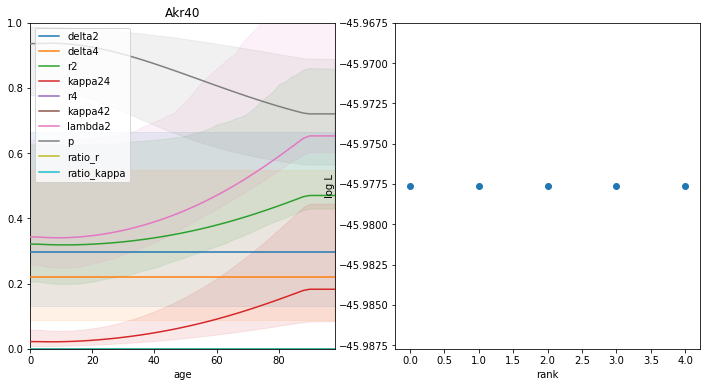

In [61]:
for name, result in results_male.items():
    if name not in ['']:
        print(name)
        fig, axs = plt.subplots(1, 2, figsize=(12,6))
        result['vis'].plot_parameter(result['point_estimate'], result['errors'], no_plot=[], axis=axs[0])
        axs[0].legend()
        axs[0].set_title(name)
        axs[0].set_ylim(0,1)

        fval = result['multistart_result']['fval']
        axs[1].scatter(np.arange(len(fval)), fval.values)
        axs[1].set_xlabel('rank')
        axs[1].set_ylabel('log L')
    #         axs[1].set_xlim(0, 100)

        plt.show()

#         display(result['vis'].get_parameter(result['point_estimate'], result['cov'], t_eval=[0, 80]))

Akr40


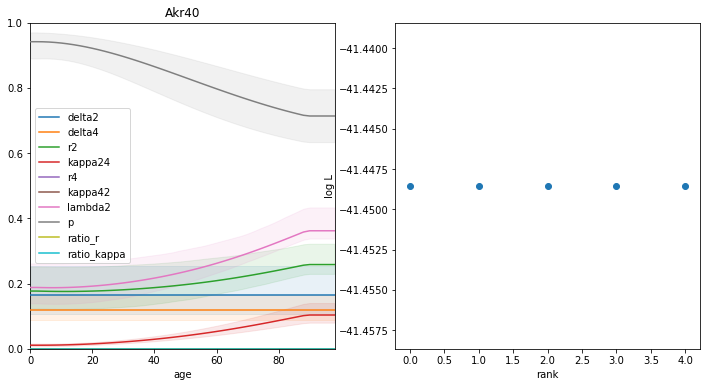

In [62]:
for name, result in results_female.items():
    if name not in ['']:
        print(name)
        fig, axs = plt.subplots(1, 2, figsize=(12,6))
        result['vis'].plot_parameter(result['point_estimate'], result['errors'], no_plot=[], axis=axs[0])
        axs[0].legend()
        axs[0].set_title(name)
        axs[0].set_ylim(0,1)

        fval = result['multistart_result']['fval']
        axs[1].scatter(np.arange(len(fval)), fval.values)
        axs[1].set_xlabel('rank')
        axs[1].set_ylabel('log L')
    #         axs[1].set_xlim(0, 100)

        plt.show()

#         display(result['vis'].get_parameter(result['point_estimate'], result['cov'], t_eval=[0, 80]))

In [ ]:
pd.DataFrame.join

In [69]:
results_male['Akr40']['vis'].get_parameter(results_male['Akr40']['point_estimate'], results_male['Akr40']['cov'], t_eval=[0, 80]).join(
results_female['Akr40']['vis'].get_parameter(results_female['Akr40']['point_estimate'], results_female['Akr40']['cov'], t_eval=[0, 80]), 
    lsuffix='_male', rsuffix='_female')

point_estimate_male  lower_male upper_male  \
time parameter                                                
0    delta2                 0.296599    0.132519   0.663838   
     delta4                 0.220365   0.0884465   0.549039   
     kappa24               0.0220397  0.00790082  0.0583684   
     kappa42                       0           0          0   
     lambda2                0.342887    0.248687    0.69099   
     p                      0.935723    0.773823   0.988146   
     r2                     0.320847    0.201512   0.670464   
     r4                            0           0          0   
     ratio_kappa                   0           0          0   
     ratio_r                       0           0          0   
80   delta2                 0.296599    0.132519   0.663838   
     delta4                 0.220365   0.0884465   0.549039   
     kappa24                0.151235   0.0683368   0.364556   
     kappa42                       0           0          0   
     lambda2                0.589698    0.541033    1.08123   
     p                      0.743538      0.5757   0.906947   
     r2                     0.438463    0.386145   0.818803   
     r4                            0           0          0   
     ratio_kappa                   0           0          0   
     ratio_r                       0           0          0   

                 point_estimate_female lower_female upper_female  
time parameter                                                    
0    delta2                   0.163837     0.106165     0.252836  
     delta4                   0.119988    0.0871981     0.165108  
     kappa24                 0.0109948   0.00706683    0.0159398  
     kappa42                         0            0            0  
     lambda2                  0.188034     0.139128     0.275917  
     p                        0.941528     0.890349     0.973171  
     r2                        0.17704     0.123808     0.266014  
     r4                              0            0            0  
     ratio_kappa                     0            0            0  
     ratio_r                         0            0            0  
80   delta2                   0.163837     0.106165     0.252836  
     delta4                   0.119988    0.0871981     0.165108  
     kappa24                 0.0866158    0.0636352     0.115547  
     kappa42                         0            0            0  
     lambda2                  0.327697     0.302712     0.397681  
     p                        0.735683     0.652891     0.826166  
     r2                       0.241081     0.207706     0.319704  
     r4                              0            0            0  
     ratio_kappa                     0            0            0  
     ratio_r                         0            0            0

### Summarized

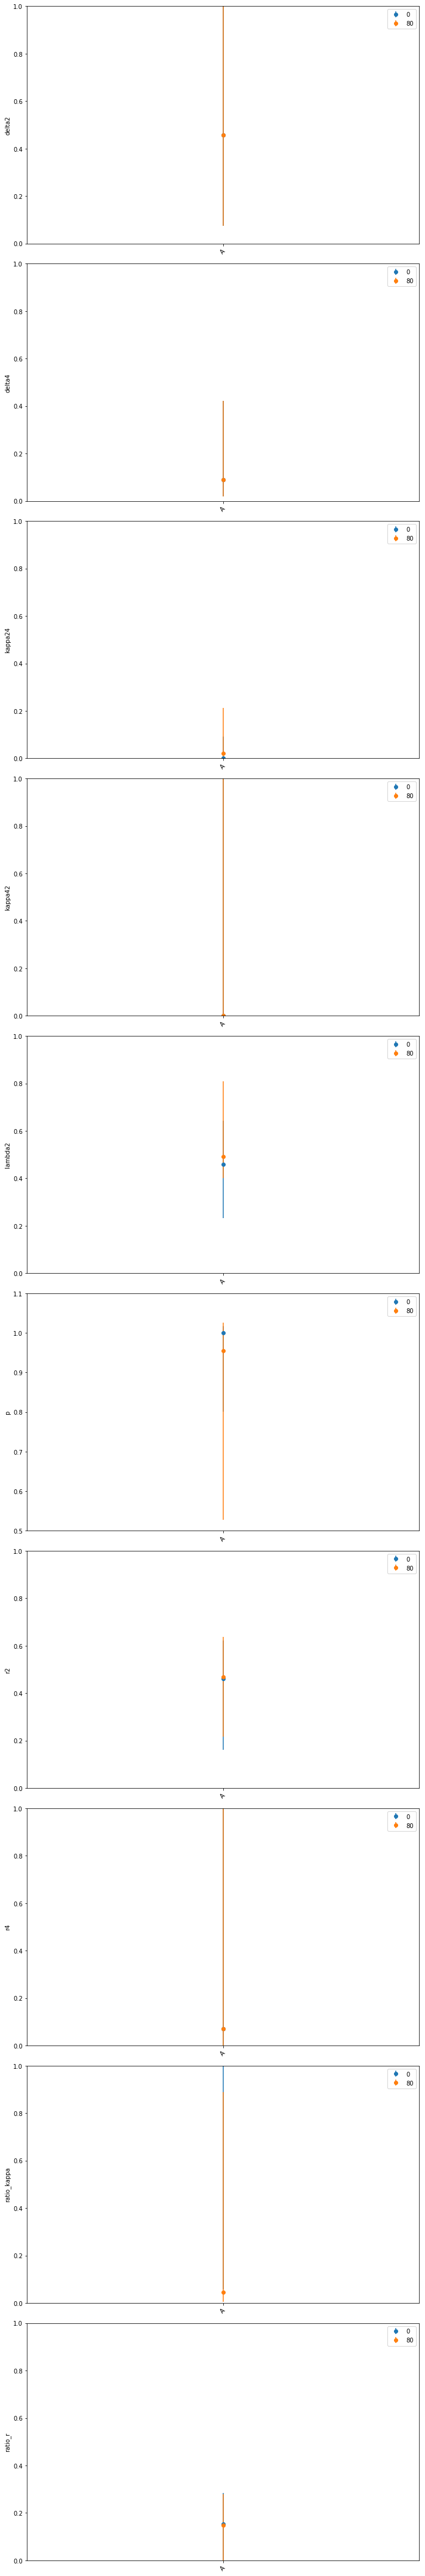

In [70]:
groupby = parameters.groupby('parameter')
fig, axs = plt.subplots(len(groupby), figsize=(10, 60))

ylimits = {'delta2': (0, 1),
           'p': (0.5, 1.1)}

for group, ax in zip(groupby, axs):
    parameter, data = group
    for time, time_data in data.groupby('time'):
        ax.errorbar('model', 'point_estimate', time_data[['ymin', 'ymax']].T.abs().values,
                    data=time_data, marker='o', ls='None', label=time)
        ax.legend()
        ax.set_ylabel(parameter)
    try:
        ax.set_ylim(ylimits[parameter])
    except:
        ax.set_ylim(0, 1)
    ax.tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

## Model selection

In [71]:
model_selection_results = pd.DataFrame(pd.Series({name: result['op'].calc_aicc(result['point_estimate']) for name, result in results.items()}, name='cAIC'))
model_selection_results['loglike'] = [result['op'].loglike_dict(result['point_estimate']) for name, result in results.items()]
model_selection_results['nparas'] = [result['model'].nparas for name, result in results.items()] 
model_selection_results['nparas'] += 1
model_selection_results = pd.DataFrame(model_selection_results)
model_selection_results['delta'] = model_selection_results['cAIC'] - model_selection_results['cAIC'].min() 
model_selection_results['w'] = np.exp(-0.5*model_selection_results['delta']) / np.exp(-0.5*model_selection_results['delta']).sum()
model_selection_results['ER'] = model_selection_results['w'].max() / model_selection_results['w']
model_selection_results.sort_values('cAIC')

,cAIC,loglike,nparas,delta,w,ER
A,-156.87123,84.546726,5,0.0,1.0,1.0
